In [1]:
import sys
import os
from PIL import Image
import time

sys.path.append(os.path.abspath('..'))

from src.data.loader import NuScenesLoader
from src.data.visuals import create_surround_montage
from src.model.vlm_client import VLMClient
from src.model.prompts import SYSTEM_PROMPT
import matplotlib.pyplot as plt
import json

# Initialize
loader = NuScenesLoader()
client = VLMClient() # Connects to localhost:1234

Loading NuScenes v1.0-mini database from /mnt/d/Nuscenes_dataset...
VLM Client initialized. Target: http://192.168.1.67:1234/v1 | Model: qwen3-vl-instruct


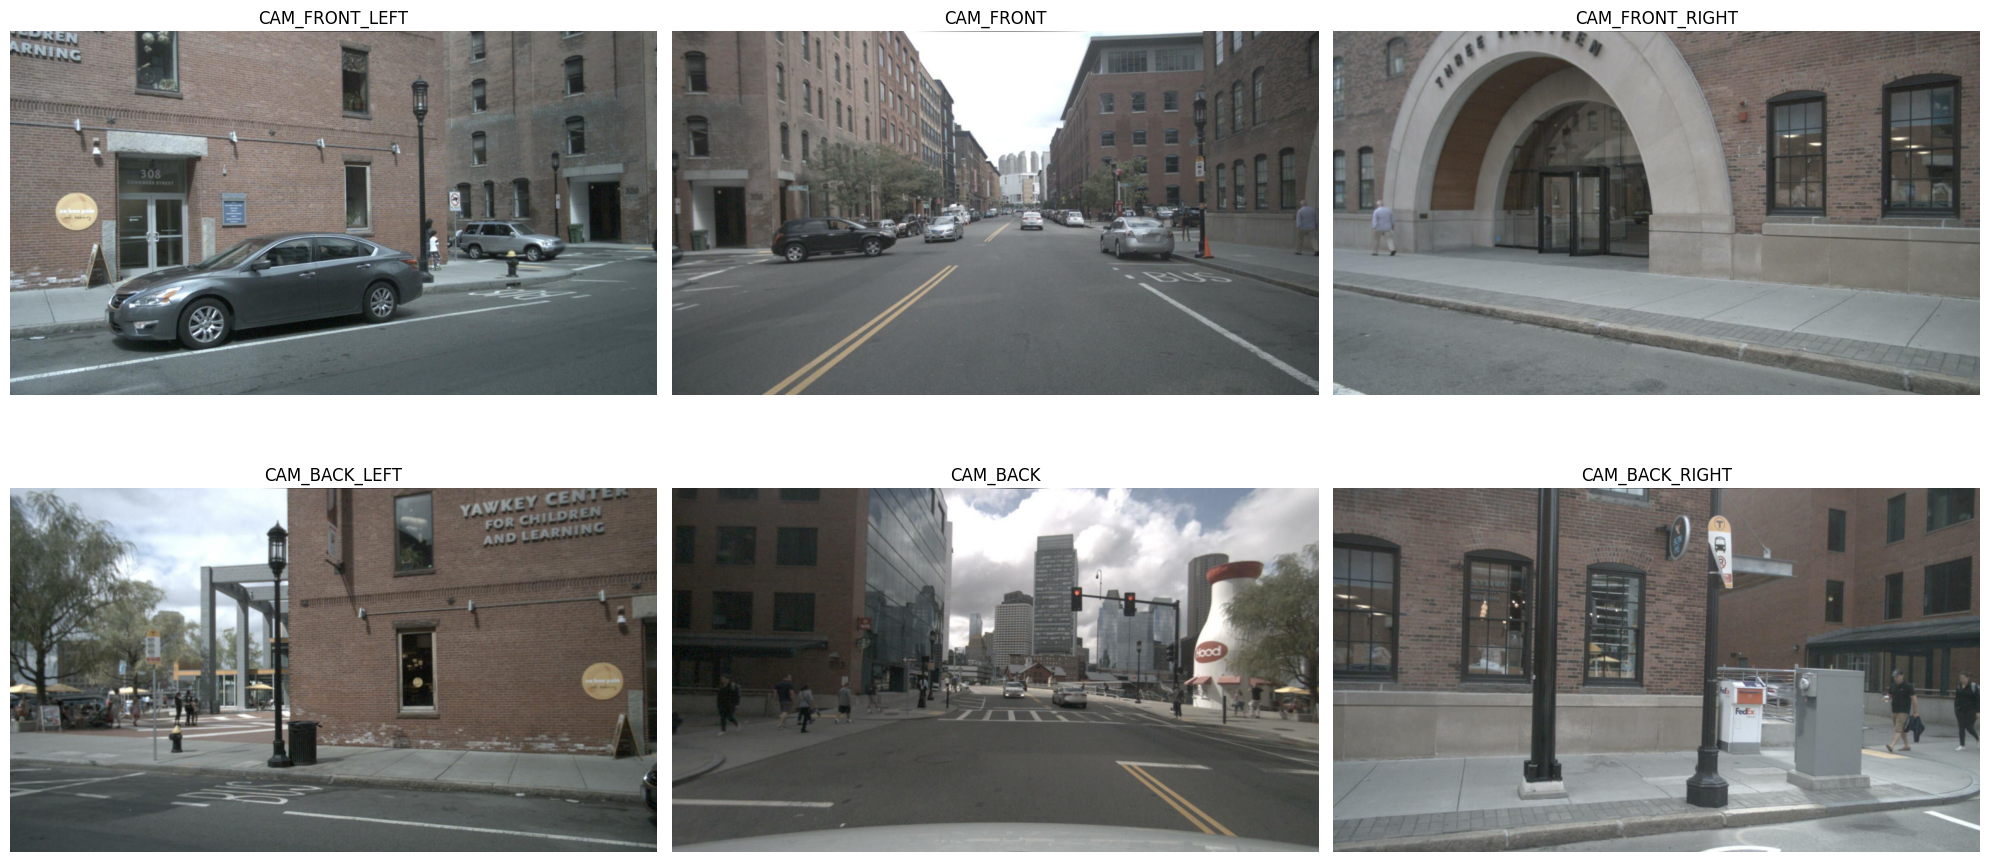

Scene Description (Ground Truth): Many peds right, wait for turning car, long bike rack left, cyclist


In [2]:
# 1. Get a specific sample
samples = loader.get_all_samples()
# Index 50 is usually a good urban scene. 
# Feel free to change this index to test different scenarios (e.g., 120, 200)
token = samples[50] 

# 2. Load Images into a Dictionary
paths = loader.get_camera_paths(token)
images = {}
for cam, path in paths.items():
    # Load and do a quick resize for visualization/inference
    # 800px is the sweet spot for Qwen3 (high detail, low token cost)
    img = Image.open(path)
    img.thumbnail((1024, 1024))
    images[cam] = img

# 3. Display the 6 Views (Human Verification)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

# Standard NuScenes Order for display
display_order = [
    "CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT",
    "CAM_BACK_LEFT", "CAM_BACK", "CAM_BACK_RIGHT"
]

for i, cam_name in enumerate(display_order):
    if cam_name in images:
        axes[i].imshow(images[cam_name])
        axes[i].set_title(cam_name)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Scene Description (Ground Truth): {loader.get_scene_description(token)}")

In [3]:
print(f"🚀 Sending 6 separate views to Qwen3-VL for analysis...")
print("Context Strategy: Interleaved Images (Text -> Image -> Text -> Image...)")

start_time = time.time()

# Run Inference
result = client.analyze_multiview(images, SYSTEM_PROMPT)

end_time = time.time()
duration = end_time - start_time

if result:
    print(f"\n✅ ANALYSIS COMPLETE ({duration:.2f}s)")
    print("-" * 60)
    print(json.dumps(result, indent=2))
    print("-" * 60)
    
    # Quick sanity check on specific hallucinations
    print("\n🔍 Hallucination Check:")
    print(f"Emergency Vehicle Detected? : {result.get('behavioral_dynamics', {}).get('vehicles', {}).get('emergency_vehicle', 'N/A')}")
    print(f"Pedestrian Action           : {result.get('behavioral_dynamics', {}).get('pedestrians', {}).get('action', 'N/A')}")
else:
    print("\n❌ Analysis Failed (Check LM Studio Server logs)")

🚀 Sending 6 separate views to Qwen3-VL for analysis...
Context Strategy: Interleaved Images (Text -> Image -> Text -> Image...)

🧠 MODEL REASONING TRACE:
------------------------------------------------------------
Alright, let's analyze the 6 camera views together to build a coherent understanding of the scene.

### Step 1: Environment and Infrastructure Analysis
- **Environment:** The time of day appears to be daytime with clear skies (based on the bright lighting in CAM_BACK and CAM_FRONT). There's no visible rain or snow. The road surface looks dry.
- **Infrastructure:** Both CAM_FRONT and CAM_BACK show a typical urban street with brick buildings lining the sides. Traffic lights are visible in CAM_BACK, showing red signals.

### Step 2: Behavioral Dynamics
- **Vehicles:** In CAM_FRONT, there are several cars parked along the curb. In CAM_BACK, more vehicles are visible further down the road, including what appears to be a white van and other cars.
- **Pedestrians:** Pedestrian acti